<h1>Under- and Over-fitting</h1>
<p style='text-align:justify'><b>Under-fitting</b> happens when the model has a very high bias and is unable to capture the complex patterns in the data, that means the model is simpler than needed. This leads to higher training and validation errors since the model is not complex enough to classify the underlying data. 

<p style='text-align: justify'><b>Over-fitting</b> is the opposite in the sense that the model is too complex (or higher model) and captures even the noise in the data and the model starts to memorize the data. Therefore in this case one would observe a very low test error value. However, when it would fail to generalize to both the validation and test sets.
The goal is to hit the optimal sweet spot, therefore, we need to find the optimal fitting point where the model has a smaller gap between the training and validation error values. It should better generalization than in the other two cases.</p>

<h3>How to handle under-fitting</h3>

<ol>

<li>Increasing the model complexity - increasing the number of parameters, for instance, decrease number of dropouts.</li> 

<li>Training the model with more epochs.</li>

</ol>

<h3>How to handle over-fitting</h3>
<ol>
<li>Increasing training data </li>
<li>Create more data through image augmentation process</li>
<li>Regularization:</li>
    <ul>
    <li>Early stopping </li>
    <li>Adding L1, L2 norms to the loss function to impose penalty on network weights (parameter)</li>
    </ul>
</ol>

Source: [towards data science](https://towardsdatascience.com/techniques-for-handling-underfitting-and-overfitting-in-machine-learning-348daa2380b9)

In [2]:
import sys,os,json,glob,cv2
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Flatten, InputLayer, Dense, Dropout, BatchNormalization,Conv2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import Accuracy,Recall,PrecisionAtRecall,RecallAtPrecision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

seed = 42
tf.random.set_seed(seed=seed)

train_file_path = '/Users/paulosgidyelew/Desktop/Capstone_Project/data/tensor_flow_data/train/'
js_file_path = '/Users/paulosgidyelew/Desktop/Capstone_Project/data/kaggle_data/'

/Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
images_dict = {
                'cbb': [i for i in glob.glob(train_file_path+'cbb/*.jpg')],
                'cbsd': [i for i in glob.glob(train_file_path+'cbsd/*.jpg')],
                'cgm': [i for i in glob.glob(train_file_path+'cgm/*.jpg')],
                'cmd': [i for i in glob.glob(train_file_path+'cmd/*.jpg')],
                'healthy': [i for i in glob.glob(train_file_path+'healthy/*.jpg')]
                }

In [4]:
labels_dict = {
                'cbb': 0,
                'cbsd': 1,
                'cgm': 2,
                'cmd': 3,
                'healthy': 4
                }

## Preprocess data: create vector from raw image file and resize it

In [5]:
# create a 3D tensor from images
X, y = [], []

for labels, images in images_dict.items():
    for image in images:
        img = cv2.imread(''.join(image))
        resized_img = cv2.resize(img, dsize=(224,224))
        X.append(resized_img)
        y.append(labels_dict[labels])

In [6]:
# create an numpy_array
X=np.array(X)
y=np.array(y)

In [7]:
# rescale X
X = X.astype(np.float32)/ 255.
y = y.astype(np.int32)

## Data segregation into train,validation and test sets

In [8]:
# split into main and holdout sets

#X, X_test, y, y_test = train_test_split(X,y, test_size=0.1)

In [9]:
X.shape

(5656, 224, 224, 3)

In [10]:
from tensorflow.keras import utils
from sklearn.model_selection import KFold,StratifiedKFold

In [18]:
# kfold cross validation: split data into train and validation sets, 

skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

y_true, y_predicted, History = [],[],[]
k = 0
path = '../callbacks/'

for train_index, val_index in skf.split(np.zeros(X.shape[0]), y):
    k+=1
    print(f'Fold_{k}')
    #print(train_index,val_index)
   
    X_train = X[train_index]
    y_train = y[train_index]
    X_val = X[val_index]
    y_val = y[val_index]

    num_classes=5

    #y_train = utils.to_categorical(y_train, num_classes)
    #y_val = utils.to_categorical(y_val, num_classes)

    datagen = ImageDataGenerator(
                                    rotation_range = 90,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    fill_mode = 'nearest'
                                )

    datagen.fit(X_train)
    datagen.fit(X_val)


    TFL_HUB_HANDLE = 'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1'

    model = Sequential()
    model.add(InputLayer(input_shape=(224,224,3)))
    model.add(hub.KerasLayer(TFL_HUB_HANDLE,trainable=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))

    # model = Sequential([
    #                     Conv2D(16, 3, padding='same', activation='relu'),
    #                     MaxPooling2D(),
    #                     Conv2D(32, 3, padding='same', activation='relu'),
    #                     MaxPooling2D(),
    #                     Conv2D(64, 3, padding='same', activation='relu'),
    #                     MaxPooling2D(),
    #                     Flatten(),
    #                     Dense(128, activation='relu'),
    #                     Dense(5)
    #                     ])

    model.compile(optimizer=Adam(),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    # fits the model on batches with real-time data augmentation:
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                validation_data=datagen.flow(X_val, y_val, batch_size=32),
                steps_per_epoch=len(X_train) / 32, epochs=10)

    # history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
    #                     steps_per_epoch=len(X_train) / 32, epochs=1)

    H = history.history
    json.dump(H, open(path + f'H_idg_{k}.json', 'w'))

    History.append(history.history)

    probabilities = model.predict_generator(X_val)
    prediction = np.argmax(probabilities, axis=1)
    y_predicted.append(prediction)
    y_true.append(y_val)  

Fold_1
Epoch 1/10
117/117 [==============================] - 92s 736ms/step - loss: 0.9896 - accuracy: 0.6430 - val_loss: 0.7001 - val_accuracy: 0.7513
Epoch 2/10
117/117 [==============================] - 84s 712ms/step - loss: 0.7809 - accuracy: 0.7411 - val_loss: 0.6599 - val_accuracy: 0.7731
Epoch 3/10
117/117 [==============================] - 84s 710ms/step - loss: 0.7381 - accuracy: 0.7531 - val_loss: 0.6503 - val_accuracy: 0.7699
Epoch 4/10
117/117 [==============================] - 84s 711ms/step - loss: 0.6885 - accuracy: 0.7682 - val_loss: 0.6623 - val_accuracy: 0.7773
Epoch 5/10
117/117 [==============================] - 82s 696ms/step - loss: 0.6703 - accuracy: 0.7748 - val_loss: 0.6330 - val_accuracy: 0.7911
Epoch 6/10
117/117 [==============================] - 82s 697ms/step - loss: 0.6525 - accuracy: 0.7857 - val_loss: 0.6137 - val_accuracy: 0.7953
Epoch 7/10
117/117 [==============================] - 81s 684ms/step - loss: 0.6274 - accuracy: 0.7942 - val_loss: 0.6091 -

In [12]:
model.save('../saved_model/model_01')

2021-12-14 23:38:07.433671: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/saved_model/model_01/assets


INFO:tensorflow:Assets written to: /Users/paulosgidyelew/Desktop/Cassava_Disease_Classifier/cassava-classification-capstone/saved_model/model_01/assets


## Final scores after k-fold cv

In [13]:
print(f'data type: {type(y_predicted)}\nlist: {y_predicted}')

data type: <class 'list'>
list: [array([0, 4, 1, ..., 4, 4, 2]), array([1, 2, 0, ..., 4, 1, 1]), array([3, 1, 1, ..., 1, 1, 1])]


In [14]:
print(f'data type: {type(y_true)}\nlist: {y_true}')

data type: <class 'list'>
list: [array([0, 0, 0, ..., 4, 4, 4], dtype=int32), array([0, 0, 0, ..., 4, 4, 4], dtype=int32), array([0, 0, 0, ..., 4, 4, 4], dtype=int32)]


In [15]:
print(f'data type: {type(y_val)}\nlist: {y_val}')

data type: <class 'numpy.ndarray'>
list: [0 0 0 ... 4 4 4]


In [19]:
# create ndarray from the lists and pass them into the sklearn scores

y_val = np.concatenate(y_true).astype(np.int32)
y_pred = np.concatenate(y_predicted).astype(np.int32)
accuracy = accuracy_score(y_val, y_pred)
f2_score = fbeta_score(y_val, y_pred, beta=2, average='macro')
print(f'Final scores: accuracy = {accuracy.round(2)} and F2_score = {f2_score.round(2)}') 

Final scores: accuracy = 0.79 and F2_score = 0.71


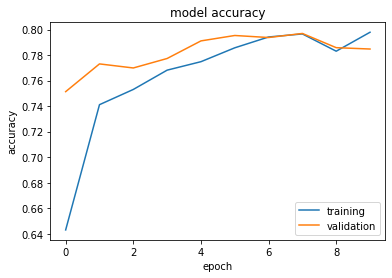

In [20]:
# plot scores

plt.plot(History[0]['accuracy'])
plt.plot(History[0]['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# Prediction on the test set

In [45]:
# make predictions on the test set and check the scores

y_test_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_prob,axis=1)
accuracy = accuracy_score(y_test, y_test_pred)
f2_score = fbeta_score(y_test, y_test_pred, beta=2, average='macro')
print(f'Final scores: accuracy = {accuracy.round(2)} and F2_score = {f2_score.round(2)}') 

Final scores: accuracy = 0.33 and F2_score = 0.17


In [55]:
print(f'data type: {type(X_test)}\nshape: {X_test.shape}')

data type: <class 'numpy.ndarray'>
shape: (566, 224, 224, 3)


In [54]:
print(f'data type: {type(y_test)}\nshape: {y_test.shape}')

data type: <class 'numpy.ndarray'>
shape: (566,)


In [48]:
y_test=y_test.ravel()
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print(f'loss: {round(loss,2)} and accuracy: {round(acc,2)}')

18/18 [==============================] - 2s 120ms/step - loss: 1.5244 - accuracy: 0.3286
loss: 1.52 and accuracy: 0.33
